In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import gradio as gr
import matplotlib.pyplot as plt

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resour

In [2]:
base_dir = "Face Mask Dataset"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")

# Augmentation + Rescale
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Data Generators
target_size = (224, 224)
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print("Labels mapping:", train_gen.class_indices)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Labels mapping: {'WithMask': 0, 'WithoutMask': 1}


In [3]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 247s 782ms/step - accuracy: 0.9168 - loss: 0.2139 - val_accuracy: 0.9663 - val_loss: 0.1034
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 233s 743ms/step - accuracy: 0.9559 - loss: 0.1248 - val_accuracy: 0.9688 - val_loss: 0.0965
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 233s 743ms/step - accuracy: 0.9629 - loss: 0.1058 - val_accuracy: 0.9812 - val_loss: 0.0642
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 232s 742ms/step - accuracy: 0.9685 - loss: 0.0914 - val_accuracy: 0.9812 - val_loss: 0.0522
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 238s 759ms/step - accuracy: 0.9705 - loss: 0.0840 - val_accuracy: 0.9900 - val_loss: 0.0381


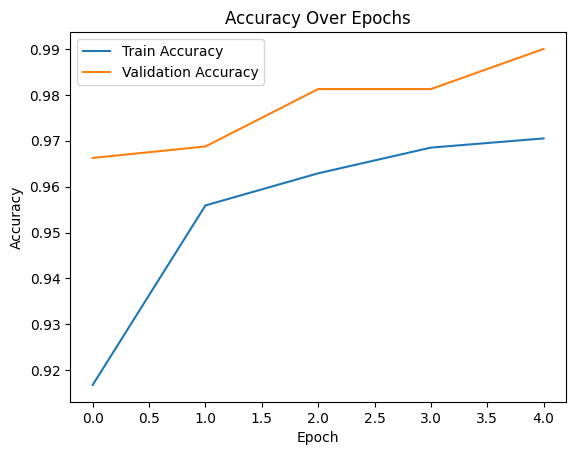

In [4]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5)
model.save("mask_detector_model.h5")
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [5]:
preds = model.predict(test_gen)
pred_labels = (preds > 0.5).astype("int32").flatten()

print("\n=== Classification Report ===")
print(classification_report(test_gen.classes, pred_labels, target_names=["Without Mask", "With Mask"]))



31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step

=== Classification Report ===
              precision    recall  f1-score   support

Without Mask       0.99      0.98      0.98       483
   With Mask       0.98      0.99      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



In [6]:
from mtcnn import MTCNN  # Ensure MTCNN is installed

class_map = train_gen.class_indices  
inv_map = {v: k for k, v in class_map.items()}

detector = MTCNN()  # Initialize the face detector

def predict_mask(img):
    # Ensure the image is a NumPy array
    img = np.array(img)

    # Detect faces in the image
    detections = detector.detect_faces(img)
    if len(detections) == 0:
        return "No face detected 😐"

    # Get the bounding box of the first detected face
    x, y, width, height = detections[0]['box']
    x, y = max(0, x), max(0, y)  # Ensure coordinates are non-negative
    cropped_face = img[y:y+height, x:x+width]

    # Resize the cropped face to the required dimensions (224x224)
    cropped_face = cv2.resize(cropped_face, (224, 224))

    # Normalize pixel values
    cropped_face = cropped_face.astype("float32") / 255.0

    # Expand dimensions to match model input
    cropped_face = np.expand_dims(cropped_face, axis=0)

    # Predict using the model
    pred = model.predict(cropped_face, verbose=0)[0][0]

    # Determine the class index and label
    class_idx = int(pred > 0.5)
    label = inv_map[class_idx]

    # Add an emoji based on the prediction
    emoji = "😷" if "With" in label else "😐"
    return f"{label} {emoji}"

gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Face Mask Detector",
    description="Upload a face image to detect if a mask is present."
).launch()

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [7]:
from mtcnn import MTCNN  # Ensure MTCNN is installed
import cv2
import numpy as np
import gradio as gr

class_map = train_gen.class_indices  
inv_map = {v: k for k, v in class_map.items()}

# Initialize the MTCNN face detector
detector = MTCNN()

# Load OpenCV's pre-trained Haar cascade for fallback
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_face(img):
    """Detect faces using MTCNN with OpenCV fallback."""
    detections = detector.detect_faces(img)
    if len(detections) > 0:
        # Use MTCNN if it detects faces
        x, y, width, height = detections[0]['box']
        x, y = max(0, x), max(0, y)  # Ensure coordinates are non-negative
        return x, y, width, height
    else:
        # Fallback to OpenCV Haar cascade
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        if len(faces) > 0:
            x, y, width, height = faces[0]
            return x, y, width, height
    return None  # No face detected

def predict_mask(img):
    # Ensure the image is a NumPy array
    img = np.array(img)

    # Detect faces in the image
    face_coords = detect_face(img)
    if face_coords is None:
        return "No face detected 😐"

    # Get the bounding box of the detected face
    x, y, width, height = face_coords
    cropped_face = img[y:y+height, x:x+width]

    # Resize the cropped face to the required dimensions (224x224)
    cropped_face = cv2.resize(cropped_face, (224, 224))

    # Normalize pixel values
    cropped_face = cropped_face.astype("float32") / 255.0

    # Expand dimensions to match model input
    cropped_face = np.expand_dims(cropped_face, axis=0)

    # Predict using the model
    pred = model.predict(cropped_face, verbose=0)[0][0]

    # Determine the class index and label
    class_idx = int(pred > 0.5)
    label = inv_map[class_idx]

    # Add an emoji based on the prediction
    emoji = "😷" if "With" in label else "😐"
    return f"{label} {emoji}"

gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Face Mask Detector",
    description="Upload a face image to detect if a mask is present."
).launch()

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [8]:
from mtcnn import MTCNN
import cv2
import numpy as np

# Initialize face detectors
detector = MTCNN()
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

class_map = train_gen.class_indices  
inv_map = {v: k for k, v in class_map.items()}

def detect_face(img):
    """Try multiple face detection methods"""
    # 1. Try MTCNN first
    faces = detector.detect_faces(img)
    if faces:
        x, y, width, height = faces[0]['box']
        return max(0, x), max(0, y), width, height

    # 2. If MTCNN fails, try Haar Cascade
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces_haar = haar_cascade.detectMultiScale(
        gray, 
        scaleFactor=1.1, 
        minNeighbors=4, 
        minSize=(30, 30)
    )
    if len(faces_haar) > 0:
        x, y, width, height = faces_haar[0]
        return x, y, width, height

    # 3. If both fail, try with the whole image
    return 0, 0, img.shape[1], img.shape[0]

def predict_mask(img):
    # Convert image to numpy array if needed
    img = np.array(img)
    
    # Handle grayscale images
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    
    # Get face coordinates
    x, y, width, height = detect_face(img)
    
    # Crop and preprocess the face
    face = img[y:y+height, x:x+width]
    face = cv2.resize(face, (224, 224))
    face = face.astype('float32') / 255.0
    face = np.expand_dims(face, axis=0)
    
    # Make prediction
    pred = model.predict(face, verbose=0)[0][0]
    class_idx = int(pred > 0.5)
    label = inv_map[class_idx]
    
    # Calculate confidence percentage
    confidence = pred if class_idx == 1 else 1 - pred
    confidence = round(confidence * 100, 2)
    
    # Add emoji based on prediction
    emoji = "😷" if "With" in label else "😐"
    
    return f"{label} ({confidence}% confident) {emoji}"

# Create and launch the Gradio interface
gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="numpy", label="Upload or take a photo"),
    outputs=gr.Text(label="Prediction"),
    title="Face Mask Detector",
    description="Upload a face image to detect if a mask is present. The image should clearly show the face.",
    examples=[
        ["example_with_mask.jpg"],
        ["example_without_mask.jpg"]
    ],
    allow_flagging="never"
).launch()

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
